##Intel Image Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/intel-image-classification.zip"

In [1]:
train_ds = "/content/seg_train/seg_train"
valid_ds = "/content/seg_test/seg_test"

In [2]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
batch_size = 64
img_height = 124
img_width = 124

In [5]:
train_dl = tf.keras.preprocessing.image_dataset_from_directory(
  train_ds,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14034 files belonging to 6 classes.


In [6]:
val_dl = tf.keras.preprocessing.image_dataset_from_directory(
  valid_ds,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 6 classes.


In [7]:
class_names = train_dl.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


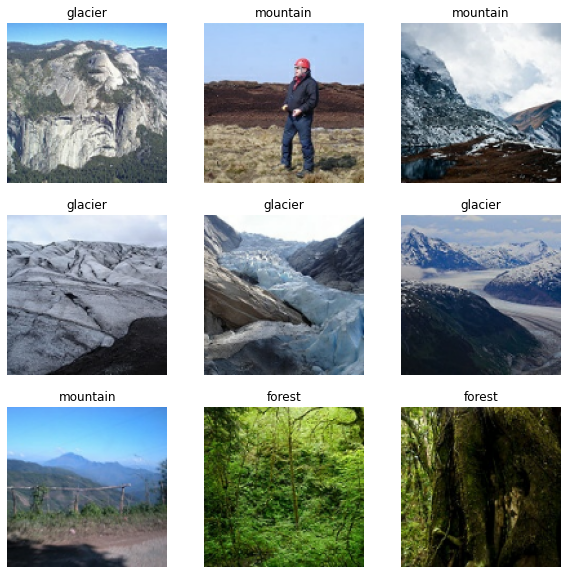

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_dl.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_dl:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 124, 124, 3)
(64,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dl = train_dl.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dl = val_dl.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

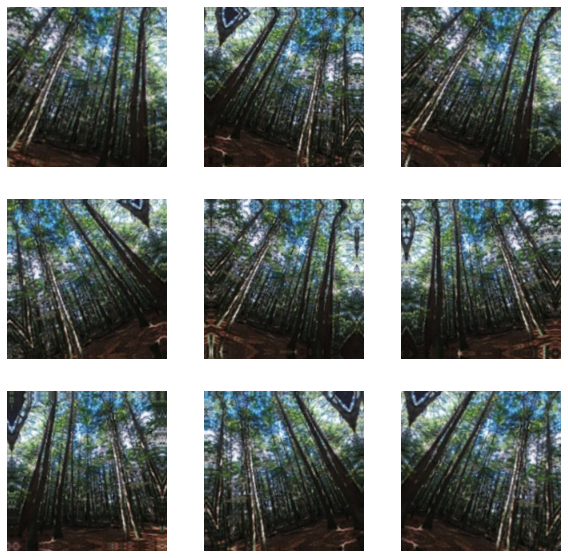

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_dl.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [12]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1000, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
checkpoint = ModelCheckpoint("model_pvp.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [earlystop, checkpoint]

In [15]:
epochs = 50
history = model.fit(
  train_dl,
  validation_data=val_dl,
  epochs=epochs,
  callbacks=callbacks,
)

Epoch 1/50
220/220 [==============================] - 33s 46ms/step - loss: 1.2641 - accuracy: 0.4881 - val_loss: 0.8266 - val_accuracy: 0.6893

Epoch 00001: val_loss improved from inf to 0.82661, saving model to model_pvp.h5
Epoch 2/50
220/220 [==============================] - 7s 34ms/step - loss: 0.8407 - accuracy: 0.6810 - val_loss: 0.7248 - val_accuracy: 0.7337

Epoch 00002: val_loss improved from 0.82661 to 0.72483, saving model to model_pvp.h5
Epoch 3/50
220/220 [==============================] - 7s 34ms/step - loss: 0.7545 - accuracy: 0.7222 - val_loss: 0.6406 - val_accuracy: 0.7717

Epoch 00003: val_loss improved from 0.72483 to 0.64059, saving model to model_pvp.h5
Epoch 4/50
220/220 [==============================] - 7s 34ms/step - loss: 0.6511 - accuracy: 0.7621 - val_loss: 0.6423 - val_accuracy: 0.7717

Epoch 00004: val_loss did not improve from 0.64059
Epoch 5/50
220/220 [==============================] - 7s 34ms/step - loss: 0.5942 - accuracy: 0.7816 - val_loss: 0.5501 -

In [16]:
!cp "/content/model_intel_image_classification.h5" "/content/drive/MyDrive"

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

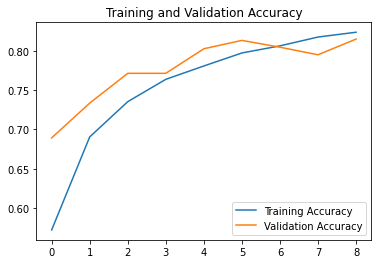

In [18]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

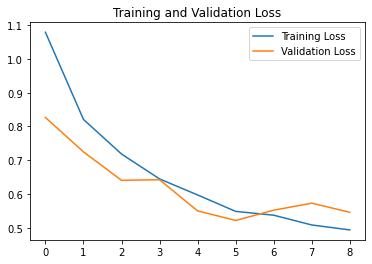

In [19]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Predictions

524288/520620 [==============================] - 0s 0us/step
This image most likely belongs to mountain with a 67.92 percent confidence.


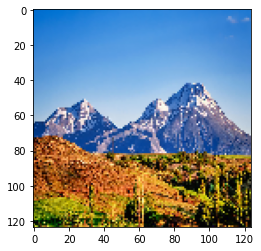

In [21]:
image_url = "https://cdn.britannica.com/67/19367-050-885866B4/Valley-Taurus-Mountains-Turkey.jpg"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

212992/212415 [==============================] - 0s 0us/step
This image most likely belongs to forest with a 94.40 percent confidence.


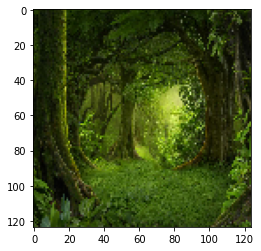

In [22]:
image_url = "https://cdn2.wanderlust.co.uk/media/1037/forest-web.jpg?anchor=center&mode=crop&width=1200&height=0&rnd=132605629110000000"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

65536/59985 [================================] - 0s 0us/step
This image most likely belongs to street with a 99.94 percent confidence.


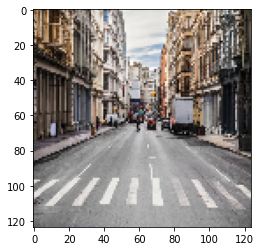

In [23]:
image_url = "https://media.istockphoto.com/photos/new-york-city-asphalt-road-on-busy-intersection-streets-with-car-at-picture-id1133502463?k=6&m=1133502463&s=612x612&w=0&h=oTnWw3cY6j2AKWQ8efMkHEgV-N4LQFNN9gWOGM-qLEs="
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

172032/166009 [===============================] - 0s 0us/step
This image most likely belongs to glacier with a 98.98 percent confidence.


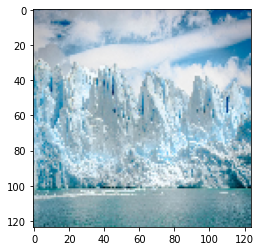

In [24]:
image_url = "https://images.unsplash.com/photo-1516569422572-d9e0514b9598?ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8Z2xhY2llcnxlbnwwfHwwfHw%3D&ixlib=rb-1.2.1&w=1000&q=80"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

49152/41980 [===================================] - 0s 0us/step
This image most likely belongs to sea with a 98.01 percent confidence.


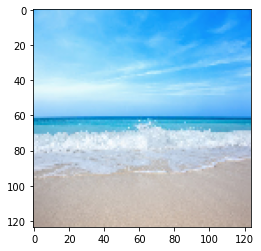

In [27]:
image_url = "https://lh3.googleusercontent.com/proxy/Cz31dc1bBq5gVk7NbLFsCBuZitKs6vZ4NX0LlGRdki-pOgPBNEpHK8J1zskyRFqh5SSVC20_me9AuVtC0rXsEqP85xIY-1TjsVBEfzzNhTvz4e4JgJxSmVxJlAeCV7w"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to buildings with a 99.71 percent confidence.


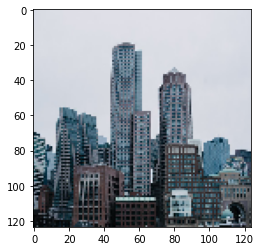

In [37]:
image_url = "https://images.unsplash.com/photo-1460472178825-e5240623afd5?ixid=MnwxMjA3fDB8MHxzZWFyY2h8NHx8YnVpbGRpbmdzfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&w=1000&q=80"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)